In [66]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline 

In [67]:
import subprocess
import json

class ClickHouse:
    
    def __init__(self, binary_path_):
        self.bin_path = binary_path_
    
    def run(self, query, silent=True):
        cmd = [self.bin_path, 'client', '-q', query, '-f', 'JSON']
        proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE) # https://unix.stackexchange.com/a/238185
        out, err = map(lambda x: x.decode('ascii'), proc.communicate())
        if not silent:
            print('CH: ' + out)
            print('CH: ' + err)
        return json.loads(out)

In [68]:
# init and test
ch = ClickHouse('/mnt/Disk3/programming/ClickHouse/build/dbms/programs/clickhouse')
print(ch.run('SELECT * from system.numbers where number > 10 limit 10'))

{'meta': [{'name': 'number', 'type': 'UInt64'}], 'data': [{'number': '11'}, {'number': '12'}, {'number': '13'}, {'number': '14'}, {'number': '15'}, {'number': '16'}, {'number': '17'}, {'number': '18'}, {'number': '19'}, {'number': '20'}], 'rows': 10, 'rows_before_limit_at_least': 65525, 'statistics': {'elapsed': 0.000197415, 'rows_read': 65536, 'bytes_read': 524288}}


In [69]:
def getTimes(count, *queries):
    result = [[] for _ in queries]
    
    for _ in range(count):
        for i in range(len(queries)):
            result[i].append(ch.run(queries[i])['statistics']['elapsed'])
    return result

TEST_RUN = 50
matplotlib.rcParams.update({'font.size': 22})

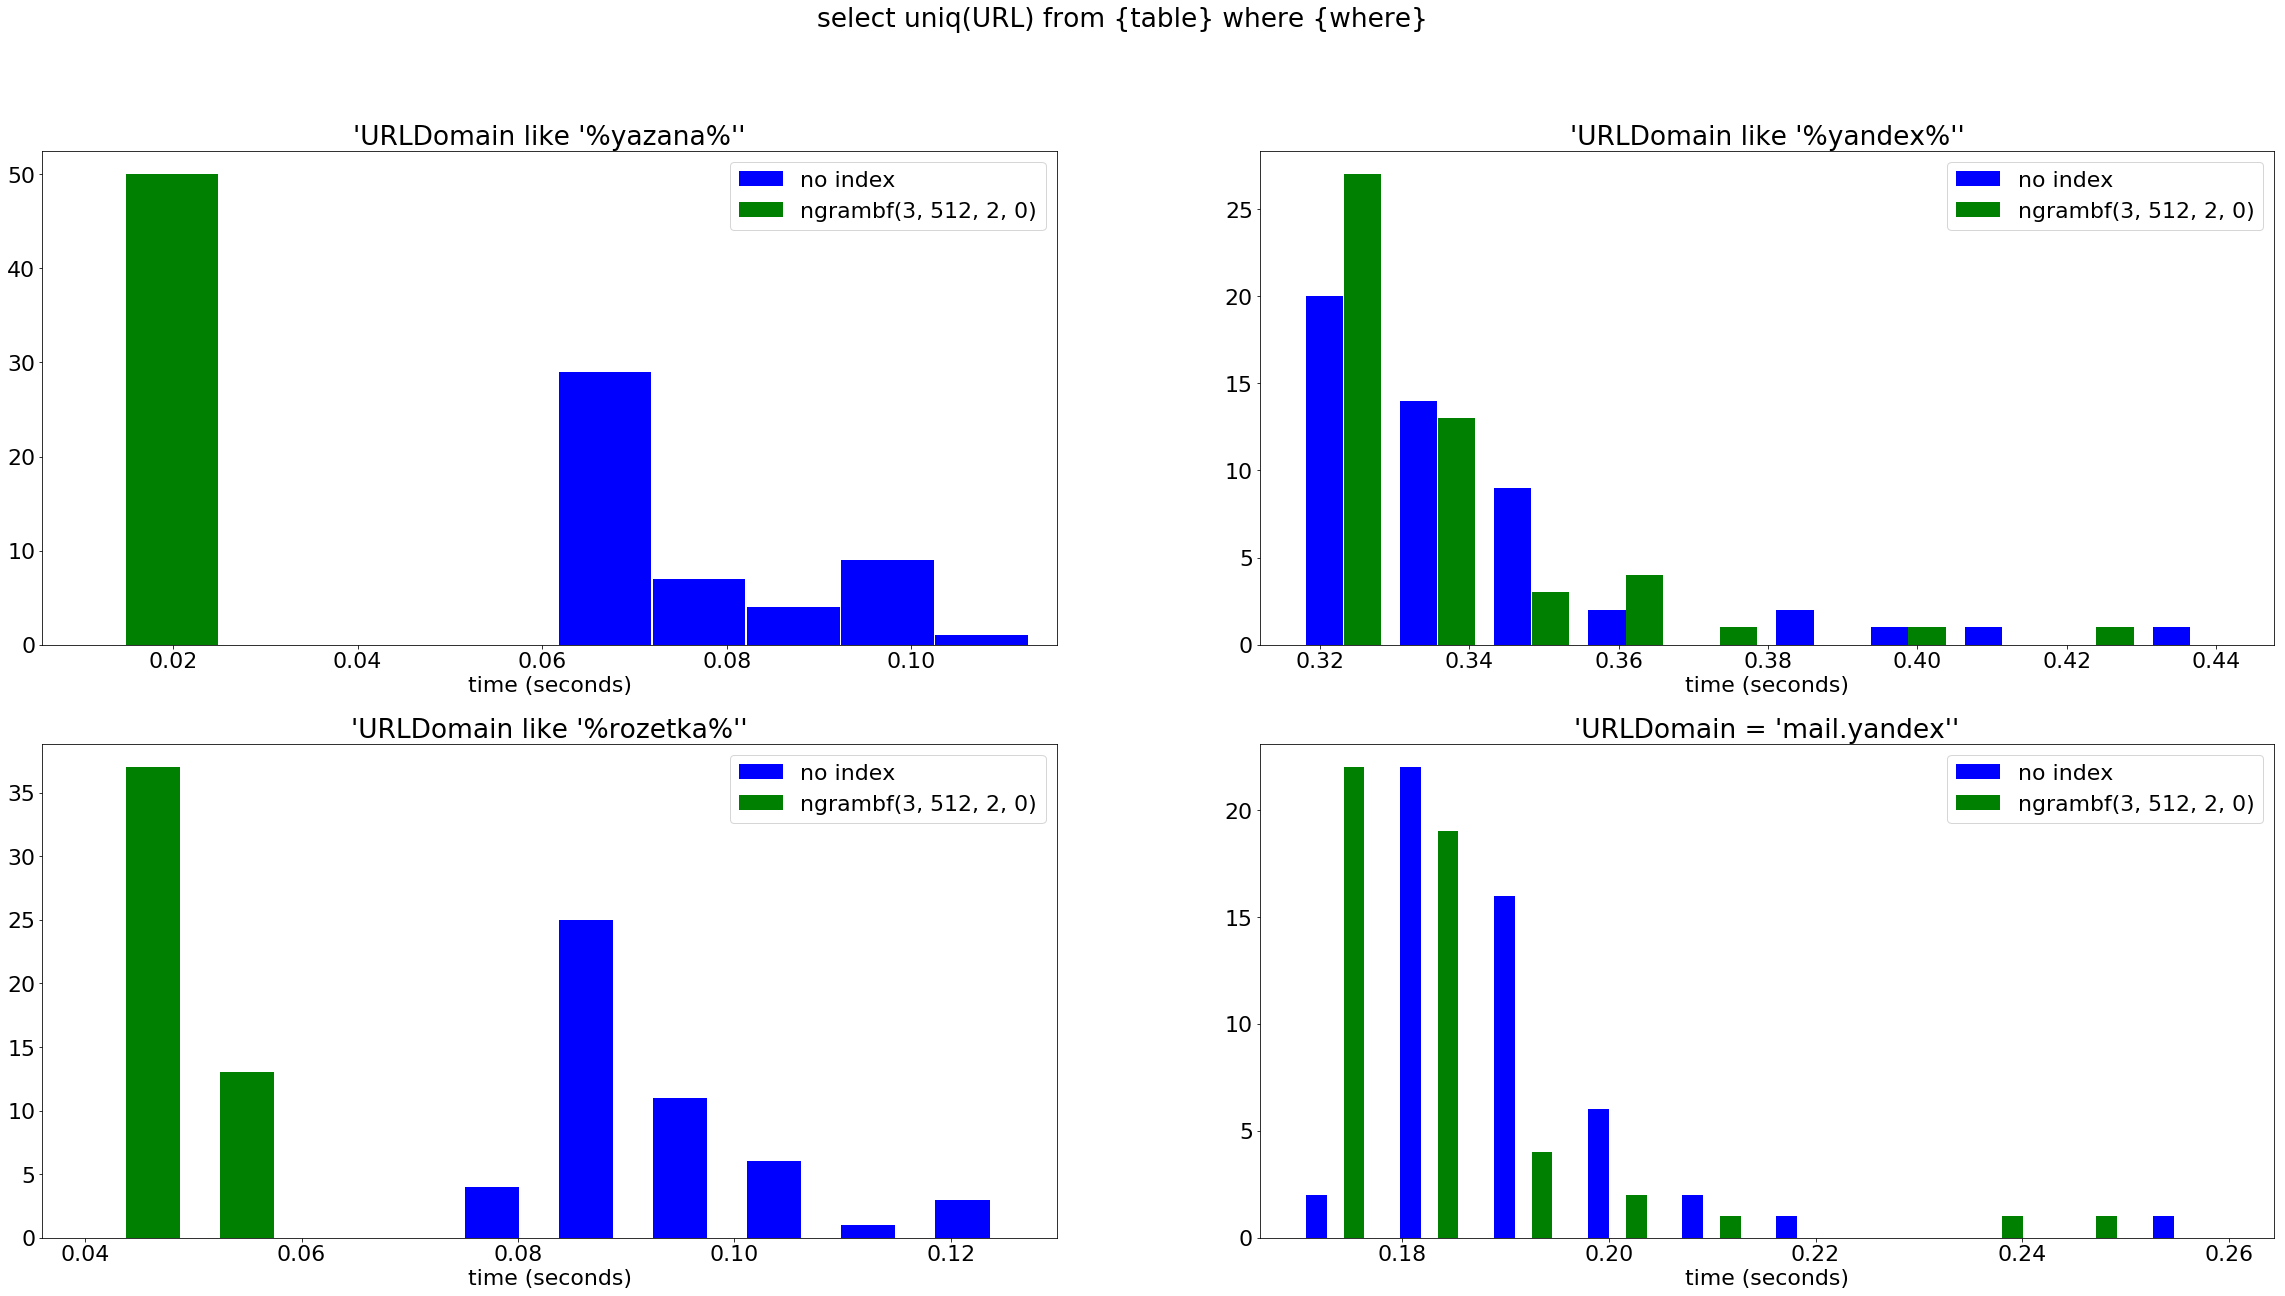

In [78]:
# URLDomain test
data_table = 'datasets.hits_v1'
no_index_table = 'datasets.hits_v1'
ngram_index_table = 'default.hits_3gram' # alter table hits_3gram add index domain (URLDomain) TYPE ngrambf(3, 512, 2, 0) GRANULARITY 1


test_tables = [no_index_table, ngram_index_table]
labels = ['no index', 'ngrambf(3, 512, 2, 0)']
colors = ['b', 'g']
query = 'select uniq(URL) from {table} where {where}'
domains= [
    'URLDomain like \'%yazana%\'',
    'URLDomain like \'%yandex%\'',
    'URLDomain like \'%rozetka%\'',
    'URLDomain = \'mail.yandex\'',
]


f, axs = plt.subplots(2, len(domains) // 2, figsize=(10 * len(domains), 20))
f.suptitle(query)

w = [0.01, 0.005, 0.005, 0.002]

for i in range(0, len(domains)):
    times = getTimes(TEST_RUN, *[query.format(table=table, where=domains[i]) for table in test_tables])
    axs[i // 2][int(i % 2)].hist(times, color = ['b', 'g'], width=w[i], label=labels)
    axs[i // 2][int(i % 2)].legend(labels)
    axs[i // 2][int(i % 2)].set_xlabel('time (seconds)')
    axs[i // 2][int(i % 2)].set_title("'{}'".format(domains[i]))

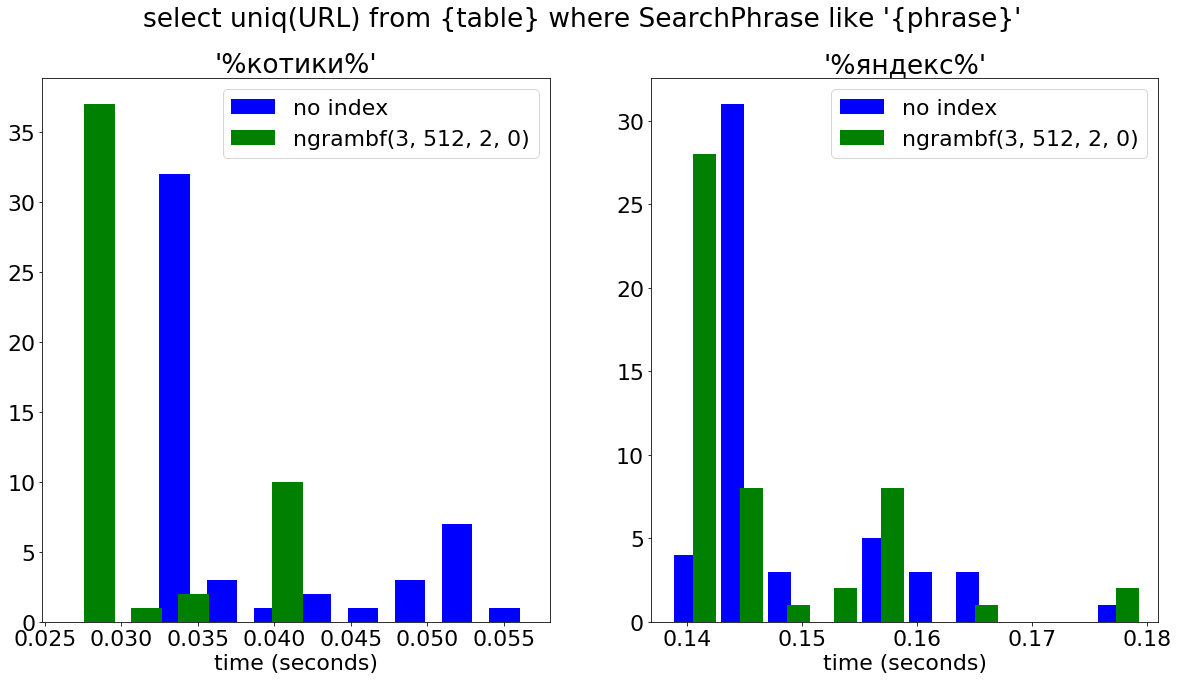

In [71]:
# SearchPhrase test
data_table = 'datasets.hits_v1'
no_index_table = 'datasets.hits_v1'
ngram_index_table = 'default.hits_3gram' # alter table hits_3gram add index domain (SearchPhrase) TYPE ngrambf(3, 512, 2, 0) GRANULARITY 1


test_tables = [no_index_table, ngram_index_table]
labels = ['no index', 'ngrambf(3, 512, 2, 0)']
colors = ['b', 'g']
query = 'select uniq(URL) from {table} where SearchPhrase like \'{phrase}\''
domains= ['%котики%', '%яндекс%']


f, axs = plt.subplots(1, len(domains), figsize=(10 * len(domains), 10))
f.suptitle(query)

for i in range(len(domains)):
    times = getTimes(TEST_RUN, *[query.format(table=table, phrase=domains[i]) for table in test_tables])
    axs[i].hist(times, color = ['b', 'g'], width=0.002,label=labels)
    axs[i].legend(labels)
    axs[i].set_xlabel('time (seconds)')
    axs[i].set_title("'{}'".format(domains[i]))

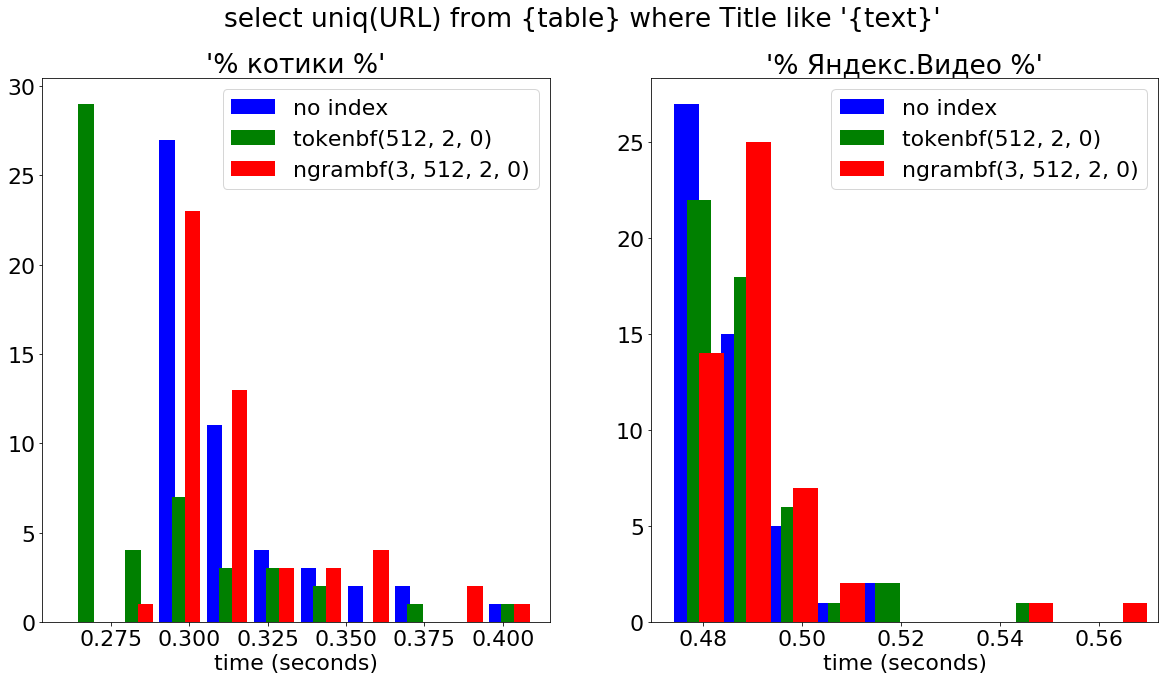

In [72]:
# Title test
data_table = 'datasets.hits_v1'
no_index_table = 'datasets.hits_v1'
token_index_table = 'default.hits_token' # alter table hits_3gram add index domain (Title) TYPE ngrambf(3, 512, 2, 0) GRANULARITY 1
ngram_index_table = 'default.hits_3gram' 

test_tables = [no_index_table, token_index_table, ngram_index_table]
labels = ['no index', 'tokenbf(512, 2, 0)', 'ngrambf(3, 512, 2, 0)']
colors = ['b', 'g', 'r']
query = 'select uniq(URL) from {table} where Title like \'{text}\''
domains= ['% котики %', '% Яндекс.Видео %']


f, axs = plt.subplots(1, len(domains), figsize=(10 * len(domains), 10))
f.suptitle(query)

for i in range(len(domains)):
    times = getTimes(TEST_RUN, *[query.format(table=table, text=domains[i]) for table in test_tables])
    axs[i].hist(times, color = colors, width=0.005, label=labels)
    axs[i].legend(labels)
    axs[i].set_xlabel('time (seconds)')
    axs[i].set_title("'{}'".format(domains[i]))

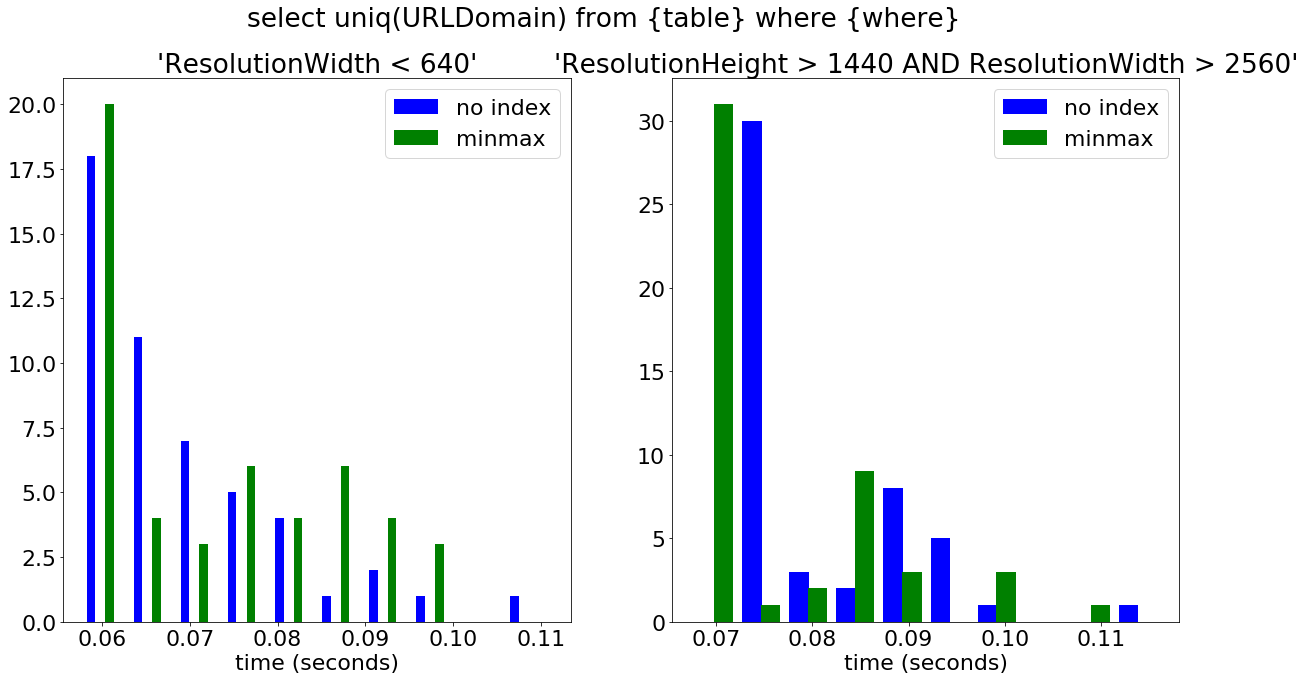

In [75]:
# minmax
data_table = 'datasets.hits_v1'
minmax_index_table = 'default.hits_minmax' # alter table hits_3gram add index domain (Title) TYPE ngrambf(3, 512, 2, 0) GRANULARITY 1 

test_tables = [no_index_table, minmax_index_table]
labels = ['no index', 'minmax']
colors = ['b', 'g']
query = 'select uniq(URLDomain) from {table} where {where}'
domains= [
    'ResolutionWidth < 640',
    'ResolutionHeight > 1440 AND ResolutionWidth > 2560'
]


f, axs = plt.subplots(1, len(domains), figsize=(10 * len(domains), 10))
f.suptitle(query)

w = [0.001, 0.002, 0.005]

for i in range(len(domains)):
    times = getTimes(TEST_RUN, *[query.format(table=table, where=domains[i]) for table in test_tables])
    axs[i].hist(times, color = colors, width=w[i], label=labels)
    axs[i].legend(labels)
    axs[i].set_xlabel('time (seconds)')
    axs[i].set_title("'{}'".format(domains[i]))

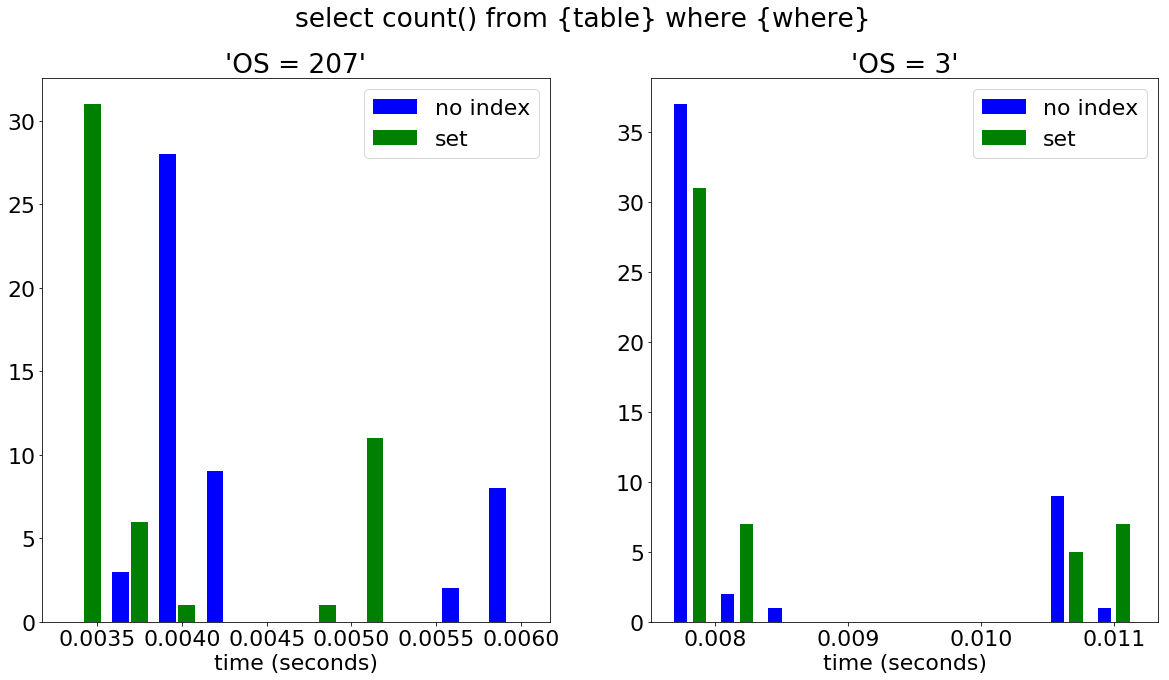

In [74]:
# set
data_table = 'datasets.hits_v1'
set_index_table = 'default.hits_set' # alter table hits_3gram add index domain (Title) TYPE ngrambf(3, 512, 2, 0) GRANULARITY 1 

test_tables = [no_index_table, set_index_table]
labels = ['no index', 'set']
colors = ['b', 'g']
query = 'select count() from {table} where {where}'
domains= ['OS = 207', 'OS = 3']


f, axs = plt.subplots(1, len(domains), figsize=(10 * len(domains), 10))
f.suptitle(query)

w = [0.0001, 0.0001]

for i in range(len(domains)):
    times = getTimes(TEST_RUN, *[query.format(table=table, where=domains[i]) for table in test_tables])
    axs[i].hist(times, color = colors, width=w[i], label=labels)
    axs[i].legend(labels)
    axs[i].set_xlabel('time (seconds)')
    axs[i].set_title("'{}'".format(domains[i]))